# IMERG w/ h5py

The Integrated Multi-satellitE Retrievals for GPM (IMERG) is the unified U.S. algorithm that provides the multi-satellite precipitation product for the U.S. GPM team.

Minor Version 06B is the current version of the data set. Older versions will no longer be available and have been superseded by Version 06B.

The precipitation estimates from the various precipitation-relevant satellite passive microwave (PMW) sensors comprising the GPM constellation are computed using the 2017 version of the Goddard Profiling Algorithm (GPROF2017), then gridded, intercalibrated to the GPM Combined Ku Radar-Radiometer Algorithm (CORRA) product, and merged into half-hourly 0.1°x0.1° (roughly 10x10 km) fields. Note that CORRA is adjusted to the monthly Global Precipitation Climatology Project (GPCP) Satellite-Gauge (SG) product over high-latitude ocean and tropical land to correct known biases.

See: https://disc.gsfc.nasa.gov/datasets/GPM_3IMERGM_06/summary for more information

In [1]:
%matplotlib inline
import h5pyd as h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.animation as animation

In [2]:
# open file in read-only mode
f = h5py.File("/shared/NASA/IMERG/3B-MO.MS.MRG.3IMERG.20210701-S000000-E235959.07.V06B.HDF5", mode="r")

In [3]:
# list contents of file - contains just one top-level object "Grid"
list(f)

['Grid']

In [4]:
# get reference to Grid group and list contents of sub-group
grid_grp = f["Grid"]
list(grid_grp)

['gaugeRelativeWeighting',
 'lat',
 'lat_bnds',
 'latv',
 'lon',
 'lon_bnds',
 'lonv',
 'nv',
 'precipitation',
 'precipitationQualityIndex',
 'probabilityLiquidPrecipitation',
 'randomError',
 'time',
 'time_bnds']

In [5]:
# get description of each object in grid group
for k in grid_grp:
    h5obj = grid_grp[k]
    print(f"{k}: {h5obj}")

gaugeRelativeWeighting: <HDF5 dataset "gaugeRelativeWeighting": shape (1, 3600, 1800), type "<i2">
lat: <HDF5 dataset "lat": shape (1800,), type "<f4">
lat_bnds: <HDF5 dataset "lat_bnds": shape (1800, 2), type "<f4">
latv: <HDF5 dataset "latv": shape (2,), type "<i4">
lon: <HDF5 dataset "lon": shape (3600,), type "<f4">
lon_bnds: <HDF5 dataset "lon_bnds": shape (3600, 2), type "<f4">
lonv: <HDF5 dataset "lonv": shape (2,), type "<i4">
nv: <HDF5 dataset "nv": shape (2,), type "<i4">
precipitation: <HDF5 dataset "precipitation": shape (1, 3600, 1800), type "<f4">
precipitationQualityIndex: <HDF5 dataset "precipitationQualityIndex": shape (1, 3600, 1800), type "<f4">
probabilityLiquidPrecipitation: <HDF5 dataset "probabilityLiquidPrecipitation": shape (1, 3600, 1800), type "<i2">
randomError: <HDF5 dataset "randomError": shape (1, 3600, 1800), type "<f4">
time: <HDF5 dataset "time": shape (1,), type "<i4">
time_bnds: <HDF5 dataset "time_bnds": shape (1, 2), type "<i4">


In [6]:
# get reference to precipitation dataset
precip = grid_grp["precipitation"]  # f["/Grid/precipitation"] would be equivlanet

In [7]:
# take a look at the attributes attached to this dataset
for k in precip.attrs:
    attr = precip.attrs[k]
    print(f"{k}: {attr}")

DimensionNames: b'time,lon,lat'
Units: b'mm/hr'
units: b'mm/hr'
coordinates: b'time lon lat'
_FillValue: -9999.900390625
CodeMissingValue: b'-9999.9'
DIMENSION_LIST: [array([b'datasets/d-fcdb76f7-7913ea77-145b-7badec-f8a79c'], dtype='|S48')
 array([b'datasets/d-fcdb76f7-7913ea77-e5cd-981459-9cca86'], dtype='|S48')
 array([b'datasets/d-fcdb76f7-7913ea77-61f8-e718a5-4c48df'], dtype='|S48')]


In [8]:
# get dimensions of dataset
precip.shape

(1, 3600, 1800)

In [9]:
# chunk shape shows how the datsaet is internally organized
precip.chunks

(1, 290, 1800)

In [10]:
# get dataset type
precip.dtype

dtype('float32')

In [11]:
# fillvalue is default value for uninitialized elements
precip.fillvalue

0.0

In [12]:
# dataset uses gzip compression
precip.compression

'gzip'

In [13]:
# get the number of MBs (uncompressed) in the dataset
(np.prod(precip.shape) * precip.dtype.itemsize) // (1024*1024)

24

In [14]:
# grab some values from the dataset using slicing
precip[0,128,600:610]

array([0.20035842, 0.20295405, 0.21037963, 0.20869878, 0.21381764,
       0.21068193, 0.2222308 , 0.23729026, 0.24570344, 0.25175893],
      dtype=float32)

In [15]:
# this is small enough that we can read the entire dataset into memory
%time data = precip[0,:,:]

CPU times: user 107 ms, sys: 49.7 ms, total: 157 ms
Wall time: 235 ms


In [16]:
# note the rank got reduced since first axis has just one element
data.shape

(3600, 1800)

In [17]:
# min value of -9999.9 is likely used to indicate non-relevant items
data.min(), data.max(), data.mean()

(-9999.9, 2.5165014, -2326.8618)

In [18]:
# get the non-missing values
non_fill = data[data > -9999]

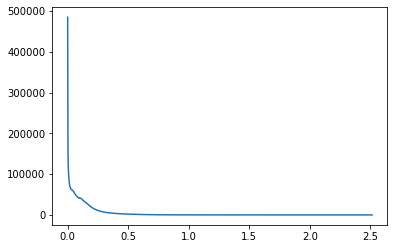

In [19]:
# plot a histogram
histo = np.histogram(non_fill, bins=1000)
plt.plot(histo[1][:-1], histo[0])

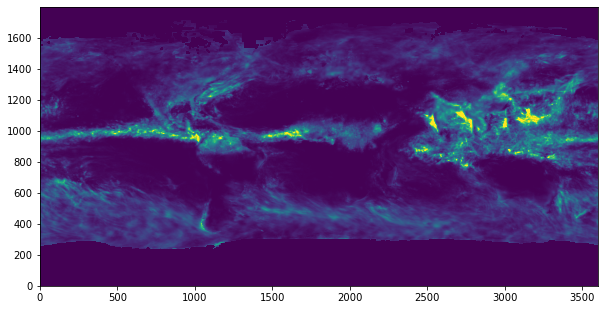

In [20]:
# try plotting the data
# transpose array so x-axis will be the longitude dimension
plt.figure(1, figsize=(10,10),dpi=72)
plt.imshow(np.transpose(data), origin="lower", vmin=0, vmax=1.0)  

In [21]:
# dimension scales are one-dimensional datasets that can be used to 
# provide coordinate values along each dimension of the parent dataset
len(precip.dims)

3

In [22]:
# each dimension can have multiple scales, but in this case
# there is one scale per dimension
for i in range(len(precip.dims)):
    dimscale = precip.dims[i]
    print(dimscale[0])

<HDF5 dataset "time": shape (1,), type "<i4">
<HDF5 dataset "lon": shape (3600,), type "<f4">
<HDF5 dataset "lat": shape (1800,), type "<f4">
